<a href="https://colab.research.google.com/github/rachit-shah/adbi-project/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BASE IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import pickle
import time

## Load Data

In [2]:
# CODE FOR READING DATA FROM DOODLE DRIVE IN COLLAB  
'''
from google.colab import drive
drive.mount('/content/drive/')
!pwd
!ls
data = pd.read_csv('/content/drive/MyDrive/NLP_datasets/spam.csv').rename(columns={'sms':'text'})
data['text_length'] = data['text'].apply(lambda x: len(x.split()))
data.head()
'''
# CODE FOR READING DATA FROM LOCAL DRIVE
df = pd.read_csv('dataset/spam.csv').rename(columns={'sms':'text'})
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [3]:
# NLTK
import nltk
nltk.download('popular')
import nltk.corpus
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer

# Word cloud
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/anshu/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!

In [4]:
# KERAS IMPORTS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding

2024-04-24 15:20:24.825582: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-24 15:20:24.825621: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
# SCIKIT LEARN IMPORTS
from sklearn.feature_extraction import text 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

ALL Categories:


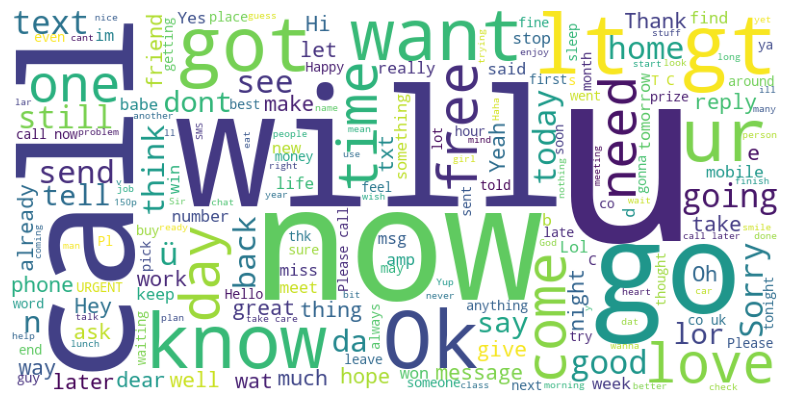

In [6]:

#WordCloud
words = ' '.join(df.loc[:, 'text'])
wordcloud = WordCloud( 
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=800,
                      height=400
            ).generate(words)
print("ALL Categories:")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


## Label Encoder
#### Use inverse_transform at the end after predicting

In [7]:
#Split training and test set using stratified sampling and test size of 20%
y = df['label']
X = df['text']
X_train, X_test, y_train, y_test  = train_test_split(X,y,stratify=y, test_size=0.2, random_state=123)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('before: %s ...' %y_train[:5])

#Transform label names to unique number using label encoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train)

before: 1020    0
788     1
4668    0
1893    1
245     0
Name: label, dtype: int64 ...
after: [0 1 0 ... 0 0 1] ...


In [8]:
print(np.bincount(y_train))
print(y.value_counts())
print(le.inverse_transform([i for i in range(2)]))

[3861  598]
0    4827
1     747
Name: label, dtype: int64
[0 1]


## Preprocess Data - (split by \n, remove periods, remove slashes)

In [9]:
#Parameters for hyperparameter  tuning
dropout = 0.3
bidirectional = False
EMBEDDING_DIM = 50
traina = True #embeedding layer trainable

In [10]:
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n"))

In [11]:
X_train = pd.DataFrame({'text':X_train})
X_test = pd.DataFrame({'text':X_test})

In [12]:
#Preprocess both train and test separately
X_train['text'] = preprocess(X_train['text'])
X_test['text'] = preprocess(X_test['text'])

In [13]:
#Stop Words and Lemmatization   
lemmatizer = WordNetLemmatizer()
stopw = nltk.corpus.stopwords.words('english')
punct = string.punctuation
punct = word_tokenize(punct)
punct += ['.','``','...','\'s','--','-','n\'t','\'']
stopw += punct
def token_stop(text):
    global stopw
    global lemmatizer
    words = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]
    return filtered
  
X_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
X_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])

In [14]:
X_test['text']

0       [today, 'm, workin, free, oso, gee, thgt, u, w...
1                                    [mean, website, yes]
2       [science, tell, chocolate, melt, sunlight, ple...
3                            [gud, mrng, dear, nice, day]
4                                     [k, best, congrats]
                              ...                        
1110    [dunno, lei, shd, b, driving, lor, co, go, sch...
1111    [u, dogbreath, sounding, like, jan, c, thats,...
1112    [getting, touch, folk, waiting, company, txt, ...
1113                                   [r, u, scratching]
1114    [urgent, 2nd, attempt, contact, u., £900, priz...
Name: text, Length: 1115, dtype: object

In [15]:
texts = np.array(X_train['text'])
test_text = np.array(X_test['text'])

In [16]:
test_text

array([list(['today', "'m", 'workin', 'free', 'oso', 'gee', 'thgt', 'u', 'workin', 'ur', 'fren', 'shop']),
       list(['mean', 'website', 'yes']),
       list(['science', 'tell', 'chocolate', 'melt', 'sunlight', 'please', 'walk', 'sunlight', 'bcoz', 'want', 'loss', 'sweet', 'friend']),
       ...,
       list(['getting', 'touch', 'folk', 'waiting', 'company', 'txt', 'back', 'name', 'age', 'opt', 'enjoy', 'community', '150p/sms']),
       list(['r', 'u', 'scratching']),
       list(['urgent', '2nd', 'attempt', 'contact', 'u.', '£900', 'prize', 'yesterday', 'still', 'awaiting', 'collection', 'claim', 'call', '09061702893.', 'acl03530150pm'])],
      dtype=object)

In [17]:
#Choose max sequence length with optimal sequence length based on box plot
#Load glove model embeddings corresponding to best dimensions from hyperparameter tuning
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
VALIDATION_SPLIT = 0.2
embeddings_index = {}
with open('./models/glove.6B.50d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [18]:
#Create data with tokenizer word_index. Neglect words which are not in word_index
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

#Split training and validation data with 20% split. So final is training 64%, validation 16% and test 20% of whole data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

xtrain = data[:-nb_validation_samples]
ytrain = labels[:-nb_validation_samples]
xval = data[-nb_validation_samples:]
yval = labels[-nb_validation_samples:]

Found 7796 unique tokens.
Shape of data tensor: (4459, 1000)
Shape of label tensor: (4459, 2)


In [19]:
#Create glove embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [20]:
#Keras Glove Embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=traina)

In [21]:
#Map label name to its index
labels_index = {}
for i in range(2):
  name = le.inverse_transform([i])[0]
  labels_index[name] = i
labels_index

{0: 0, 1: 1}

## Train Model

# RNN

In [22]:
#Model Architecture
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
if bidirectional:
  x = Bidirectional(LSTM(100,dropout=dropout))(embedded_sequences)
else:
  x = LSTM(100,dropout=dropout)(embedded_sequences)
preds = Dense(len(labels_index), activation='softmax')(x)
lstm_model = Model(sequence_input, preds)
lstm_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

2024-04-24 15:20:32.414758: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-24 15:20:32.417858: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-24 15:20:32.581286: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 15:20:32.581342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 960 computeCapability: 5.2
coreClock: 1.291GHz coreCount: 8 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.46GiB/s
2024-04-24 15:20:32.581501: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such

In [23]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 50)          389850    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 450,452
Trainable params: 450,452
Non-trainable params: 0
_________________________________________________________________


In [24]:
#Callbacks - checkpointer, early stopping and tensorboard
model_name = "RNN-"+str(dropout)+"-"+str(EMBEDDING_DIM)+"-Trainable-"+str(traina)+"-bidrect-"+str(bidirectional)
checkpointer = ModelCheckpoint(model_name + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1,
                               save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tensorboard_rnn = TensorBoard(log_dir='./Graph_RNN', histogram_freq=0,write_graph=True, write_images=True)

2024-04-24 15:20:32.824547: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-24 15:20:32.824603: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-24 15:20:32.824659: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2024-04-24 15:20:32.825105: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcupti.so.11.0'; dlerror: libcupti.so.11.0: cannot open shared object file: No such file or directory
2024-04-24 15:20:32.892971: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so
2024-04-24 15:20:32.919609: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-24 15:20:32.919734: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [25]:
#Train Model
stmillis = int(round(time.time() * 1000))
history = lstm_model.fit(xtrain, ytrain, validation_data=(xval, yval),
          epochs=5, batch_size=128, callbacks=[checkpointer, early_stopping,tensorboard_rnn])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

2024-04-24 15:20:33.078459: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-24 15:20:33.079158: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3599995000 Hz


Epoch 1/5
 1/28 [>.............................] - ETA: 1:24 - loss: 0.6602 - acc: 0.6641

2024-04-24 15:20:36.257713: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-24 15:20:36.257771: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/28 [=>............................] - ETA: 40s - loss: 0.6063 - acc: 0.7266 

2024-04-24 15:20:37.769709: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-24 15:20:37.771036: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2024-04-24 15:20:37.961547: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-04-24 15:20:38.142982: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-24 15:20:38.559819: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./Graph_RNN/train/plugins/profile/2024_04_24_15_20_38
2024-04-24 15:20:38.785723: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./Graph_RNN/train/plugins/profile/2024_04_24_15_20_38/DESKTOP-M0A6HS0.trace.json.gz
2024-04-24 15:20:38.930734: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./G

28/28 [==============================] - 45s 2s/step - loss: 0.3569 - acc: 0.8645 - val_loss: 0.1138 - val_acc: 0.9618

Epoch 00001: val_loss improved from inf to 0.11384, saving model to RNN-0.3-50-Trainable-True-bidrect-False_weights.01-0.11.hdf5
Epoch 2/5
28/28 [==============================] - 45s 2s/step - loss: 0.1161 - acc: 0.9592 - val_loss: 0.1206 - val_acc: 0.9551

Epoch 00002: val_loss did not improve from 0.11384
Epoch 3/5
28/28 [==============================] - 40s 1s/step - loss: 0.0920 - acc: 0.9673 - val_loss: 0.0760 - val_acc: 0.9731

Epoch 00003: val_loss improved from 0.11384 to 0.07600, saving model to RNN-0.3-50-Trainable-True-bidrect-False_weights.03-0.08.hdf5
Epoch 4/5
28/28 [==============================] - 48s 2s/step - loss: 0.0674 - acc: 0.9803 - val_loss: 0.0766 - val_acc: 0.9798

Epoch 00004: val_loss did not improve from 0.07600
Epoch 5/5
28/28 [==============================] - 59s 2s/step - loss: 0.0697 - acc: 0.9771 - val_loss: 0.0762 - val_acc: 0.97

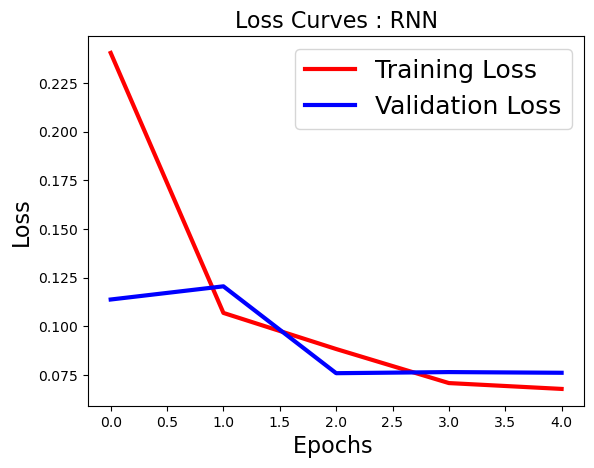

In [26]:
#Plot loss curve
fig=plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves : RNN',fontsize=16)
fig.savefig(model_name+'.png')
plt.show()

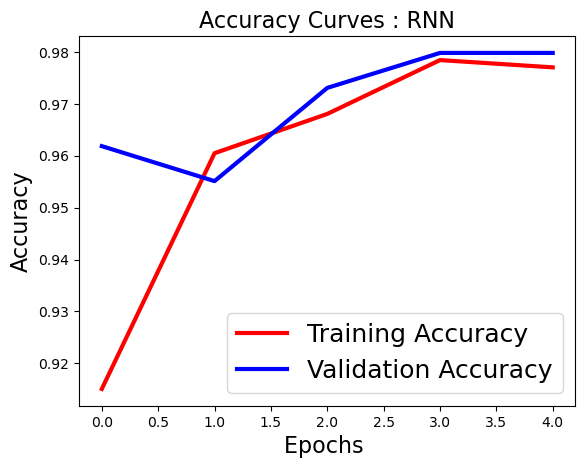

In [27]:
#Plot accuracy curve
fig=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig.savefig(model_name+'-ACC'+'.png')
plt.show()

In [28]:
model_name

'RNN-0.3-50-Trainable-True-bidrect-False'

In [29]:
# Save the trained weights
lstm_model.save("./models/"+model_name + ".h5")

# Save model config as json
model_json = lstm_model.to_json()
with open("./models/"+model_name + ".json", "w") as json_file:
    json_file.write(model_json)

## Predict on Test Data

In [30]:
def find_test_acc(prediction):
  count = 0
  t = 0
  for pred in prediction:
    p = pred.argmax()
    name = le.inverse_transform([p])
    if name == y_test.loc[count]:
      t+=1
    count+=1
  print('Test Accuracy:',(t/count)*100,"%")

In [31]:
def predict_test(model):
  #Tokenize test data and apply model prediction
  sequences = tokenizer.texts_to_sequences(test_text)
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels.shape)
  prediction = model.predict(data)
  find_test_acc(prediction)

In [32]:
#Load the weights of the model which had the best validation loss
model_filename = './models/RNN-0.3-50-Trainable-True-bidrect-False.h5'

In [33]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
if bidirectional:
  x = Bidirectional(LSTM(100,dropout=dropout))(embedded_sequences)
else:
  x = LSTM(100,dropout=dropout)(embedded_sequences)
preds = Dense(len(labels_index), activation='softmax')(x)
best_model = Model(sequence_input, preds)

best_model.load_weights(model_filename)

best_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [34]:

#Final test accuracy on the best model
predict_test(best_model)

Shape of data tensor: (1115, 1000)
Shape of label tensor: (4459, 2)
Test Accuracy: 97.57847533632287 %


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(best_model, to_file='./models/rnn_model.png', show_shapes=True, show_layer_names=True)


In [ ]:
from PIL import Image
display(Image.open('./models/rnn_model.png'))